# Uncertainty estimation

Test the second hypothesis that IT regime has bring down not just the inflation persistance and average inflation, but also the inflation uncertainty, measured by the conditional volatilty from GARCH models. 

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 
import pmdarima.arima as pm
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test
from scipy import stats
import arch

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

## Data loading and preprocessing

In [44]:
inf1 = pd.read_csv('output/inflation_SeasAdj.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date)
inf1 = inf1.drop("date", axis = 1)
# inf1.head()

In [3]:
# inf1.v_cpi.loc['1992-01-01':'2021-12-01'].plot()

In [45]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1993-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

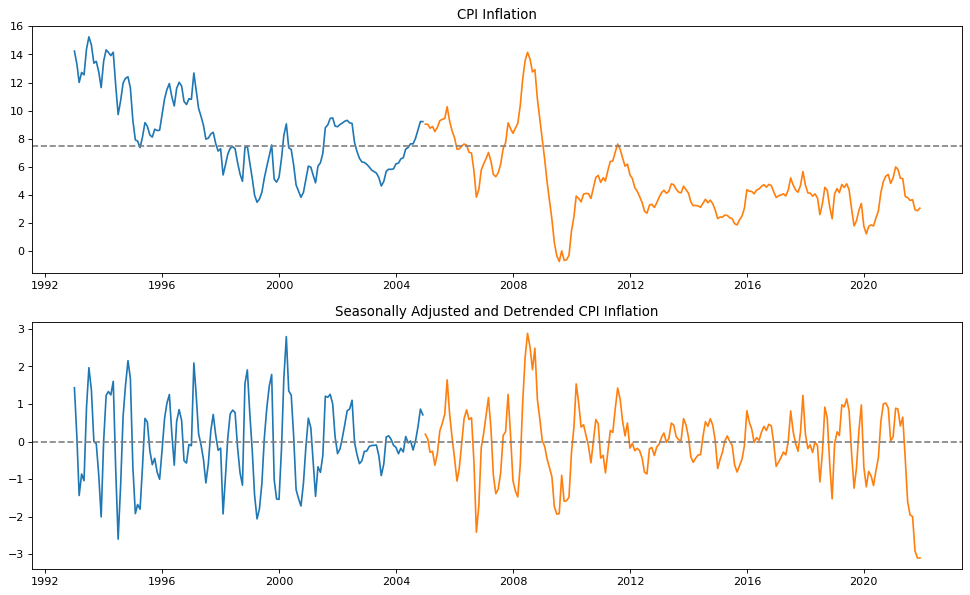

In [46]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


Controls

In [80]:
from fredapi import Fred
fred = Fred(api_key='ca6ea25f72db47e2d070a76b7e9e639b')
CorePCE = fred.get_series('PCEPILFE')
PCE = fred.get_series('PCEPI')
CpiUS = fred.get_series('CPIAUCSL')
Pet = fred.get_series('WTISPLC')

controls = pd.DataFrame()
controls['pce'] = PCE.pct_change(12)*100
controls['core_pce'] = CorePCE.pct_change(12)*100
controls['cpiUS'] = CpiUS.pct_change(12)*100
controls['pet'] = Pet.pct_change(12)*100

cont = controls.loc['1993-01-01':'2021-12-01']
# precont = controls.loc['1992-01-01':'2004-12-01']
# itcont  = controls.loc['2005-01-01':'2021-12-01']

# cont.head()

In [81]:
food = pd.read_csv('data/13072022/Food_price_indices_data_jul825.csv', delimiter=';')
food.index = pd.to_datetime(food.Date)#, format='%d/%m/%Y')
food = food.drop("Date", axis = 1)
cont['fao_Index'] = food['fao_Index'].pct_change(12)*100

In [82]:
other_gt = pd.read_csv('data/13072022/other_gt.csv', delimiter=';')
other_gt.index = pd.to_datetime(other_gt.Date, format='%d/%m/%Y')
other_gt = other_gt.drop("Date", axis = 1)
other_gt['ner_gt'] = other_gt['ner_gt'].pct_change(12)*100
other_gt['omas_mn'] = other_gt['omas_mn'].pct_change(12)*100
other_gt['emision'] = other_gt['emision'].pct_change(12)*100
cont['ner_gt'] = other_gt['ner_gt'].loc['1993-01-01':'2021-12-01']
cont['omas_mn'] = other_gt['omas_mn'].loc['1993-01-01':'2021-12-01']
cont['emision'] = other_gt['emision'].loc['1993-01-01':'2021-12-01']

cont2 = cont.dropna()

In [9]:
# cont2.head()

In [83]:
# cont = controls.loc['1992-01-01':'2021-12-01']
precont = cont.loc['1993-01-01':'2004-12-01']
itcont  = cont.loc['2005-01-01':'2021-12-01']
cont.to_csv('output/controls.csv')

## Modeling

### GARCH(1,1) with zero mean on Seasonally Adjusted Inflation

$\pi_t = \sigma_t e_t, e_t \sim iid N(0,1)$<br>
$\sigma_t^2 = \omega + \alpha \pi_{t-1}^2 + \beta \sigma_{t-1}^2$

In [52]:
np.mean(simdf['inf_seasAdj'])

-0.03408774704018667

In [85]:
# GARCH(1,1)
garch = arch.arch_model(simdf['inf_seasAdj'], p=1, q=1, o=0, mean='zero', rescale=False, dist='gaussian', vol='garch')
resa1 = garch.fit(disp=False)
resa1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -421.268
Distribution:                  Normal   AIC:                           848.536
Method:            Maximum Likelihood   BIC:                           860.093
                                        No. Observations:                  348
Date:                Mon, Jul 18 2022   Df Residuals:                      348
Time:                        12:22:12   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0216  1.523e-02      1.419      0.156 [-8.240e-03,5.145e-02]
alpha[1]       0.2102  6.453e-02      3.258  1.121e-03    [8.378e-02,  0.337]
beta[1]        0.7803  7.327e-02     10.649  1.770e-26      [  0.637,  0.924]
=============================================================================

Covariance estimator: robust
"""

In [86]:
# Period averages and differences
ITVolMean = resa1.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean = resa1.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean - ITVolMean)

difference: 0.1963539973290893


Mean difference test

In [87]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(resa1.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        resa1.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
6.123588051161115e-07


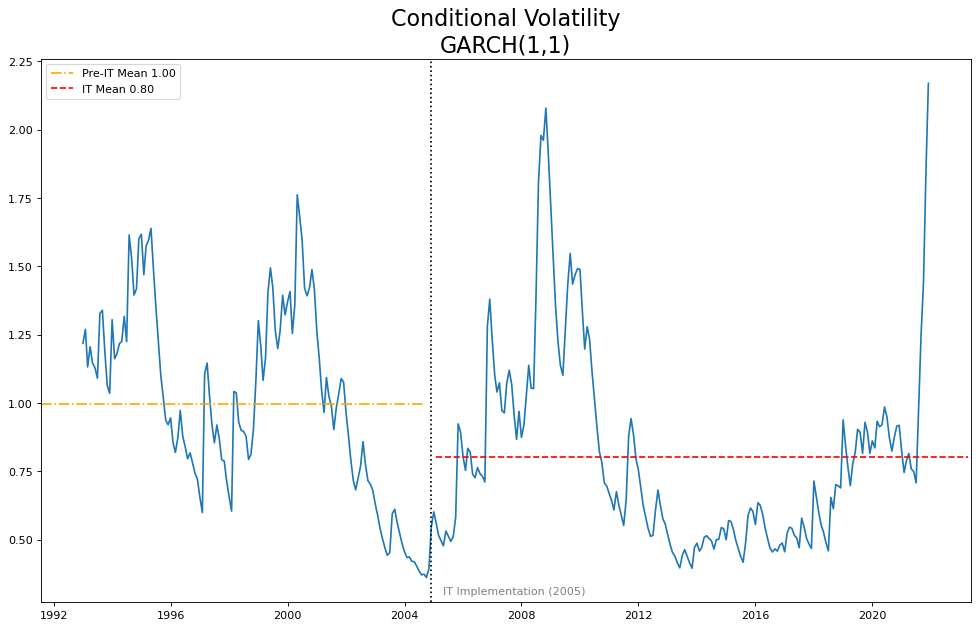

In [88]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-05-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

plt.figure(figsize=(15,9), dpi= 80)
plt.plot(resa1.conditional_volatility)
plt.title('Conditional Volatility\nGARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean, color='orange', linestyle='-.', label = 'Pre-IT Mean {:.2f}'.format(PreVolMean))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean, color='red', linestyle='--', label = 'IT Mean {:.2f}'.format(ITVolMean))
plt.legend()

### GARCH(1,1) with constant mean on Observed Inflation


$\pi_t = \mu + \epsilon_t, \mu = Const$<br>
$\epsilon_t = \sigma_t e_t, e_t \sim iid N(0,1)$<br>
$\sigma_t^2 = \omega + \alpha \pi_{t-1}^2 + \beta \sigma_{t-1}^2$


Observed Inflation

In [57]:
np.mean(simdf['v_cpi'])

6.370762451407195

In [91]:
# GARCH(1,1)
garch2 = arch.arch_model(simdf['v_cpi'], p=1, q=1, mean='Constant', rescale=False, dist='StudentsT', vol='garch')
resa2 = garch2.fit(disp=False)
resa2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                        v_cpi   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -742.061
Distribution:      Standardized Student's t   AIC:                           1494.12
Method:                  Maximum Likelihood   BIC:                           1513.38
                                              No. Observations:                  348
Date:                      Mon, Jul 18 2022   Df Residuals:                      347
Time:                              12:24:47   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.6293      0.607      7.622  2.488e-14 [  3.439,  5.820]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3890      1.717      0.227      0.821 [ -2.977,  3.755]
alpha[1]       0.9647      2.730      0.353      0.724 [ -4.385,  6.315]
beta[1]    1.4926e-12      2.862  5.216e-13      1.000 [ -5.609,  5.609]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu           445.0856    414.665      1.073      0.283 [-3.676e+02,1.258e+03]
=============================================================================

Covariance estimator: robust
"""

In [92]:

# Period averages and differences
ITVolMean2b = resa2.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean2b= resa2.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean2b - ITVolMean2b)

difference: 1.845418789166744


Mean difference test

In [93]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(resa2.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        resa2.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
3.916949590914227e-14


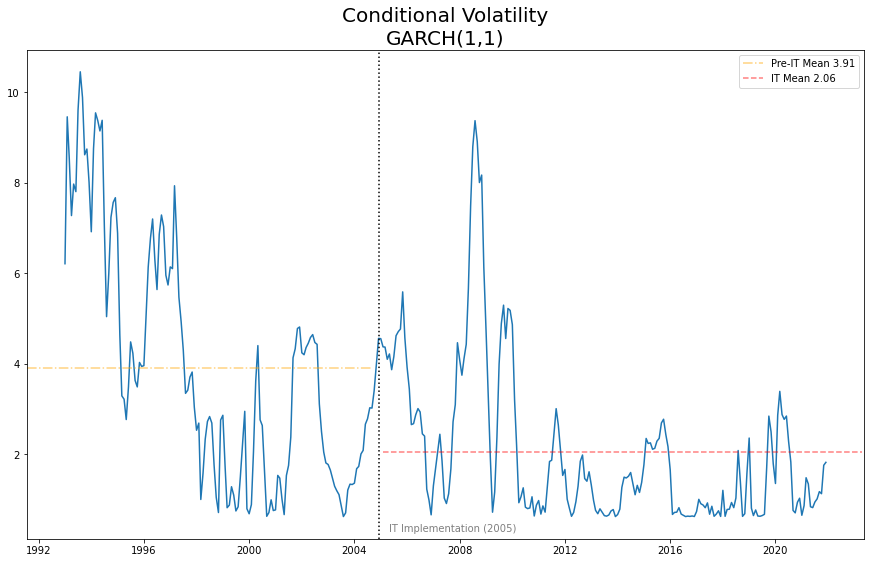

In [94]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-05-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)
plt.figure(figsize=(15,9))
plt.plot(resa2.conditional_volatility)
# res2.conditional_volatility.rolling(24).mean().plot(figsize=(15,9))
plt.title('Conditional Volatility\nGARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
plt.legend()

### ARMA(p,q) / GARCH(p,q) model

Mean model -> ARMA([p,q]) 

$\pi_t = \mu_t + \epsilon_t$<br>

$\mu_t = \mu_0 + \sum_{j=1}^{p_A} \phi_j(\pi_{t-i} - \mu) + \sum_{j=1}^{q_A}\theta_i \epsilon_{t-1}$ (ARMA Process)<br>

Volatility Model -> GARCH([p,q])

$\epsilon_t = \sigma_t e_t$ where $e_t \sim idd N(0,1)$<br>

$\sigma_t = \omega + \sum_{j=1}^{p_G} \alpha_j \epsilon_{t-1}^2 + \sum_{j=1}^{q_G} \beta_j \sigma_{t-1}^2$ (GARCH Process) 

#### Seasonally adjusted Inflation

ARMA Process Fit

In [62]:
arma1 = pm.auto_arima(simdf['inf_seasAdj'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # let model determine 'd'              
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

arma1.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=657.735, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=956.582, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=725.183, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=719.863, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=633.040, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=633.113, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=634.909, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.472, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=651.996, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=633.711, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=623.470, Time=0.44 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=608.589, Time=0.46 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=632.139, Time=0.12 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=609.607, Time=0.56 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=596.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -289.916
Date:                Mon, 18 Jul 2022   AIC                            593.833
Time:                        12:13:53   BIC                            620.798
Sample:                             0   HQIC                           604.568
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2716      0.021     59.394      0.000       1.230       1.314
ar.L2         -0.9314      0.018    -51.923      0.000      -0.967      -0.896
ma.L1         -0.3162      0.048     -6.607      0.000      -0.410      -0.222
ma.L2          0.2624      0.050      5.259      0.000       0.165       0.360
ma.L3          0.4996      0.051      9.728      0.000       0.399       0.600
ma.L4          0.2109      0.052      4.018      0.000       0.108       0.314
sigma2         0.3070      0.020     15.641      0.000       0.269       0.345
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                34.59
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA Process

In [63]:
arma_AP2 = ARIMA(endog=simdf['inf_seasAdj'], order=(2,0,4)).fit()
arma_AP2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            inf_seasAdj   No. Observations:                  348
Model:                     ARMA(2, 4)   Log Likelihood                -289.798
Method:                       css-mle   S.D. of innovations              0.554
Date:                Mon, 18 Jul 2022   AIC                            595.596
Time:                        12:13:57   BIC                            626.413
Sample:                    01-01-1993   HQIC                           607.865
                         - 12-01-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0362      0.074     -0.487      0.626      -0.182       0.110
ar.L1.inf_seasAdj     1.2717      0.026     49.031      0.000       1.221       1.323
ar.L2.inf_seasAdj    -0.9317      0.026    -35.999      0.000      -0.982      -0.881
ma.L1.inf_seasAdj    -0.3169      0.060     -5.278      0.000      -0.435      -0.199
ma.L2.inf_seasAdj     0.2623      0.048      5.515      0.000       0.169       0.356
ma.L3.inf_seasAdj     0.4996      0.046     10.879      0.000       0.410       0.590
ma.L4.inf_seasAdj     0.2104      0.056      3.773      0.000       0.101       0.320
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6825           -0.7794j            1.0360           -0.1355
AR.2            0.6825           +0.7794j            1.0360            0.1355
MA.1            0.5980           -0.8430j            1.0336           -0.1518
MA.2            0.5980           +0.8430j            1.0336            0.1518
MA.3           -1.7851           -1.1232j            2.1090           -0.4106
MA.4           -1.7851           +1.1232j            2.1090            0.4106
-----------------------------------------------------------------------------
"""

GARCH Process

In [23]:
# np.mean(arma_AP2.resid)

In [64]:
garch_AP2 = arch.arch_model(arma_AP2.resid, p=2, q=4, o=0, dist='gaussian', mean='zero', rescale=False ).fit(disp=False)
garch_AP2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -264.955
Distribution:                  Normal   AIC:                           543.911
Method:            Maximum Likelihood   BIC:                           570.876
                                        No. Observations:                  348
Date:                Mon, Jul 18 2022   Df Residuals:                      348
Time:                        12:14:01   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0103  1.896e-02      0.544      0.586 [-2.685e-02,4.749e-02]
alpha[1]       0.2663      0.170      1.569      0.117   [-6.641e-02,  0.599]
alpha[2]       0.0000      0.949      0.000      1.000      [ -1.861,  1.861]
beta[1]        0.0000      3.179      0.000      1.000      [ -6.230,  6.230]
beta[2]        0.0000      1.268      0.000      1.000      [ -2.485,  2.485]
beta[3]        0.4103      0.870      0.472      0.637      [ -1.295,  2.115]
beta[4]        0.3085      2.011      0.153      0.878      [ -3.632,  4.249]
=============================================================================

Covariance estimator: robust
"""

Estimators

In [65]:
mu_t2 = arma_AP2.predict(start=0,end=len(simdf[['inf_seasAdj']])-1)
eps_t2 = arma_AP2.resid
gamma_t2 = garch_AP2.conditional_volatility

ITVolMeanb2 = gamma_t2.loc['2005-01-01':].mean()
PreVolMeanb2 = gamma_t2.loc[:'2004-12-01'].mean()
print('difference:', PreVolMeanb2 - ITVolMeanb2)

difference: 0.1588174685109774


Mean difference test

In [66]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(garch_AP2.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        garch_AP2.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre_mean different from it_mean')
    print(t_check)

pre_mean different from it_mean
Ttest_indResult(statistic=-8.664960876113318, pvalue=1.760931072631496e-16)


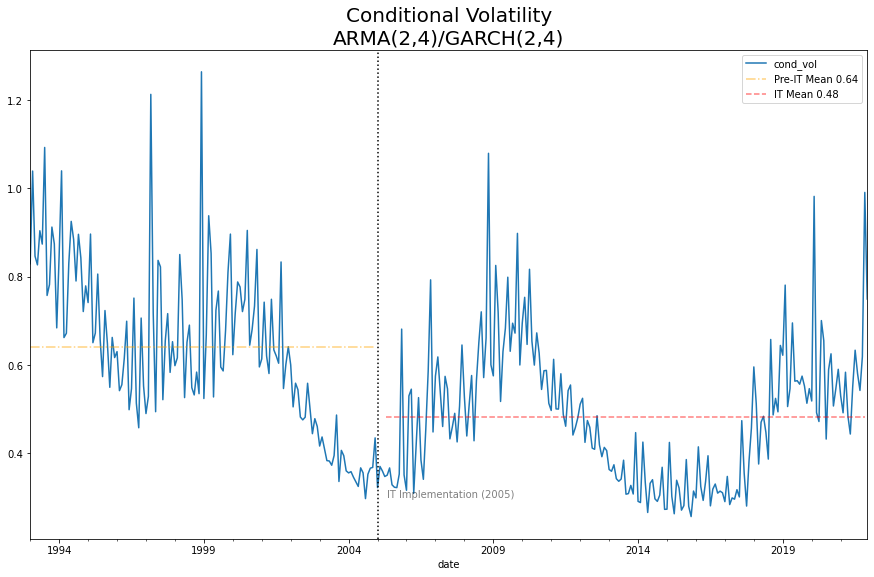

In [67]:
gamma_t2.plot(figsize=(15,9))
plt.title('Conditional Volatility\nARMA(2,4)/GARCH(2,4)', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMeanb2, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb2))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMeanb2, color='red', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb2))
plt.legend()
# plt.text(pd.to_datetime('1993-01-01'),PreVolMeanb2-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMeanb2), fontsize=10)
# plt.text(pd.to_datetime('2019-06-01'),ITVolMeanb2-0.07, 'IT Mean {:.2f}'.format(ITVolMeanb2), fontsize=10)

In [28]:
# forcCPI2 = mu_t2 + gamma_t2
# forcCPI2.plot(figsize=(15,9), label='ARMA(2,4)/GARCH(2,4)')
# # mu_t2.plot(figsize=(15,9), label='ARMA(2,4)')
# simdf['inf_seasAdj'].plot(figsize=(15,9), label='Observed')
# # mu_t.plot(figsize=(15,9), label='ARMA(1,1)')
# # gamma_t.plot(figsize=(15,9), label='GARCH(1,1)')
# plt.legend(loc='best', fontsize=15)
# plt.title('Forecasted CPI', fontsize=20)


#### Observed Inflation

ARMA Process Fit

In [68]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model1 = pm.auto_arima(simdf[['v_cpi']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # let model determine 'd'              
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model1.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=757.481, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2357.315, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=759.258, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=759.248, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=752.745, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1376.338, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=803.486, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=754.057, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=754.099, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1804.317, Time=0.01 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -372.372
Date:                Mon, 18 Jul 2022   AIC                            752.745
Time:                        12:14:14   BIC                            768.154
Sample:                             0   HQIC                           758.880
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2670      0.124      2.150      0.032       0.024       0.510
ar.L1          0.9599      0.014     67.988      0.000       0.932       0.988
ma.L1          0.3973      0.049      8.038      0.000       0.300       0.494
sigma2         0.4929      0.028     17.304      0.000       0.437       0.549
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA process

In [69]:
arma_AP = ARIMA(endog=simdf[['v_cpi']], order=(1,0,1)).fit()
arma_AP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  v_cpi   No. Observations:                  348
Model:                     ARMA(1, 1)   Log Likelihood                -372.372
Method:                       css-mle   S.D. of innovations              0.702
Date:                Mon, 18 Jul 2022   AIC                            752.745
Time:                        12:14:17   BIC                            768.154
Sample:                    01-01-1993   HQIC                           758.880
                         - 12-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6578      1.233      5.400      0.000       4.241       9.074
ar.L1.v_cpi     0.9599      0.016     59.964      0.000       0.929       0.991
ma.L1.v_cpi     0.3973      0.048      8.244      0.000       0.303       0.492
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0418           +0.0000j            1.0418            0.0000
MA.1           -2.5170           +0.0000j            2.5170            0.5000
-----------------------------------------------------------------------------
"""

GARCH process

In [70]:
garch_AP=arch.arch_model(arma_AP.resid, p=1, q=1, o=0, dist='gaussian', mean='zero', rescale=False ).fit(disp=False)
garch_AP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -354.773
Distribution:                  Normal   AIC:                           715.546
Method:            Maximum Likelihood   BIC:                           727.103
                                        No. Observations:                  348
Date:                Mon, Jul 18 2022   Df Residuals:                      348
Time:                        12:14:19   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0111  6.030e-03      1.847  6.478e-02 [-6.826e-04,2.295e-02]
alpha[1]       0.0924  2.359e-02      3.918  8.929e-05    [4.620e-02,  0.139]
beta[1]        0.8776  2.084e-02     42.109      0.000      [  0.837,  0.918]
=============================================================================

Covariance estimator: robust
"""

Estimators

In [71]:
mu_t = arma_AP.predict(start=0,end=len(simdf[['v_cpi']])-1)
eps_t = arma_AP.resid
gamma_t = garch_AP.conditional_volatility

ITVolMeanb = gamma_t.loc['2005-01-01':].mean()
PreVolMeanb = gamma_t.loc[:'2004-12-01'].mean()

Mean difference test

In [72]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(garch_AP.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        garch_AP.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
7.859322894524683e-18


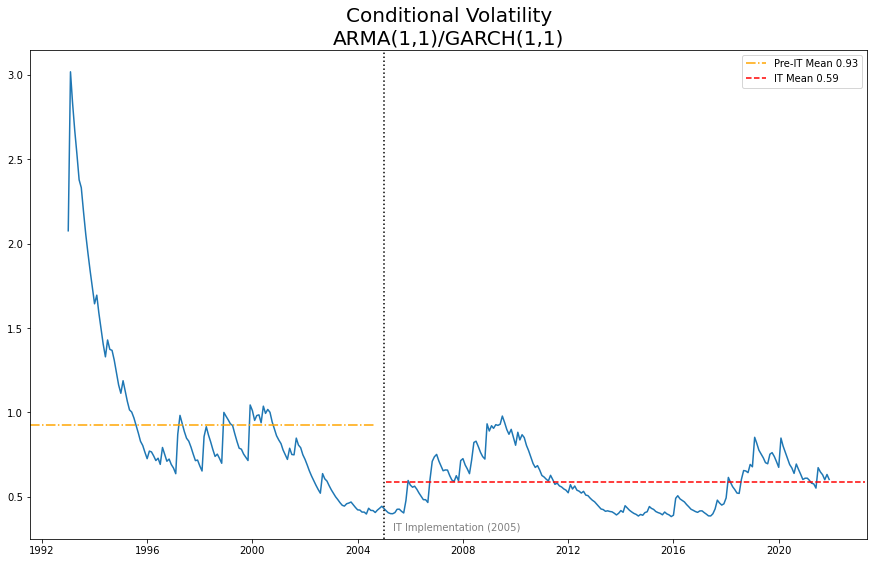

In [73]:
plt.figure(figsize=(15,9))
plt.plot(gamma_t)
plt.title('Conditional Volatility\nARMA(1,1)/GARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMeanb, color='orange', linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMeanb, color='r', linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb))
plt.legend()
# plt.text(pd.to_datetime('1993-01-01'),PreVolMeanb-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMeanb), fontsize=10)
# plt.text(pd.to_datetime('2019-06-01'),ITVolMeanb-0.07, 'IT Mean {:.2f}'.format(ITVolMeanb), fontsize=10)

In [35]:
# forcCPI = mu_t + gamma_t
# forcCPI.plot(figsize=(15,9), label='ARMA(1,1)/GARCH(1,1)')
# simdf['v_cpi'].plot(figsize=(15,9), label='Observed')
# # mu_t.plot(figsize=(15,9), label='ARMA(1,1)')
# # gamma_t.plot(figsize=(15,9), label='GARCH(1,1)')
# plt.legend(loc='best', fontsize=15)
# plt.title('Forecasted CPI', fontsize=20)


## Volatility measures graph 1

In [74]:
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-01-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

Text(0.01, -0.15, 'All differences between means are statistically significant at the 1% level')

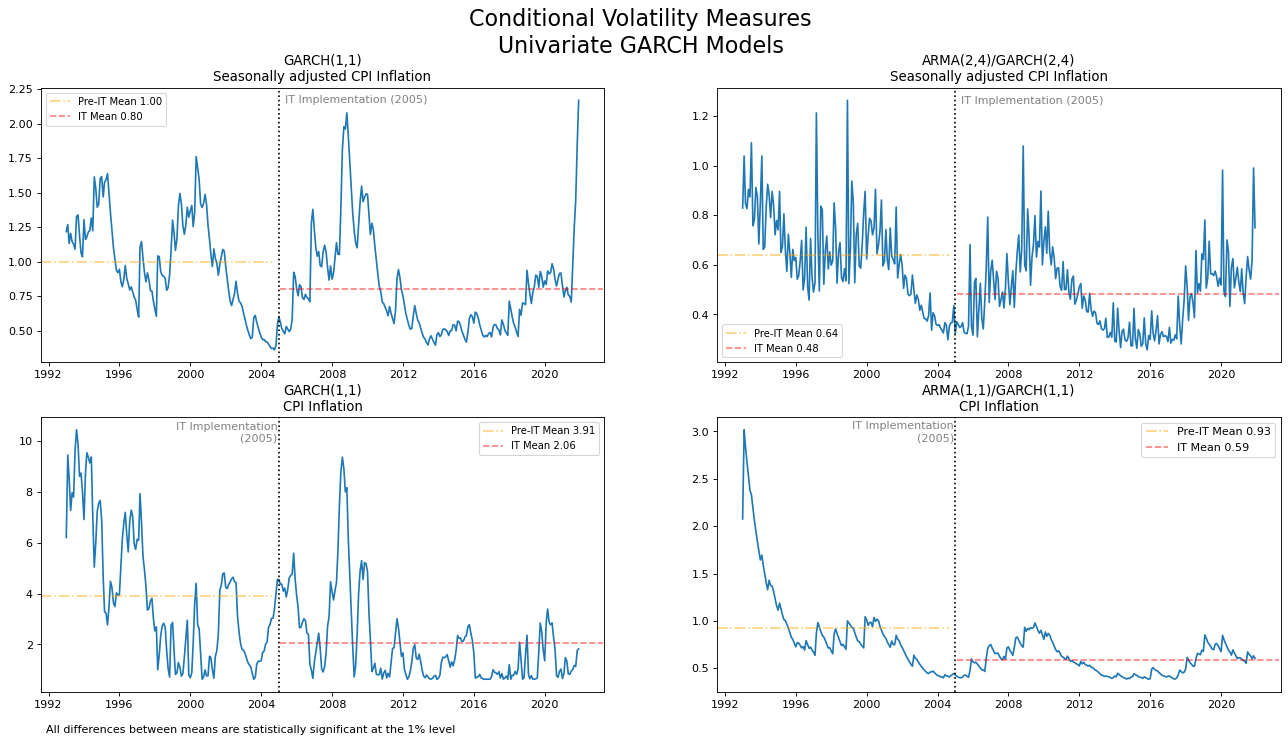

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)

plt.suptitle('Conditional Volatility Measures\nUnivariate GARCH Models', fontsize=20)

# GARCH(1,1) on Seasonally Adjusted CPI Inflation
axes[0,0].plot(resa1.conditional_volatility)
axes[0,0].set_title('GARCH(1,1)\nSeasonally adjusted CPI Inflation', fontsize=12)
axes[0,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[0,0].text(pd.to_datetime('2005-05-01'), 2.15, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
axes[0,0].axhline(xmin=x0, xmax=x1, y=PreVolMean, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean))
axes[0,0].axhline(xmin=x2, xmax=x3, y=ITVolMean, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean))
axes[0,0].legend(loc='best', fontsize=9)
# GARCH(1,1) on CPI Inflation
axes[1,0].plot(resa2.conditional_volatility)
axes[1,0].set_title('GARCH(1,1)\nCPI Inflation', fontsize=12)
axes[1,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[1,0].text(pd.to_datetime('2004-12-01'),10.0, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
axes[1,0].axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
axes[1,0].axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
axes[1,0].legend(loc='best', fontsize=9)
# ARMA(p,q) / GARCH(p,q) model on Seasonally Adjusted CPI Inflation
axes[0,1].plot(gamma_t2)
axes[0,1].set_title('ARMA(2,4)/GARCH(2,4)\nSeasonally adjusted CPI Inflation', fontsize=12)
axes[0,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[0,1].text(pd.to_datetime('2005-05-01'),1.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
axes[0,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb2, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb2))
axes[0,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb2, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb2))
axes[0,1].legend(loc='lower left', fontsize=9)
# ARMA(p,q) / GARCH(p,q) model on CPI Inflation
axes[1,1].plot(gamma_t)
axes[1,1].set_title('ARMA(1,1)/GARCH(1,1)\nCPI Inflation', fontsize=12)
axes[1,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[1,1].text(pd.to_datetime('2004-12-01'),2.90, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
axes[1,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb))
axes[1,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb))
axes[1,1].legend(loc='best', fontsize=10)

plt.text(0.01, -0.15, 
'All differences between means are statistically significant at the 1% level', fontsize=10,transform=axes[1,0].transAxes)


## Other Mean and Volatility models

Volatility Processes

- ConstantVariance: Constant volatility process
- GARCH([p, o, q, power=2]): GARCH and related model estimation
  - $\sigma_{t}^{\lambda}=\omega + \sum_{i=1}^{p}\alpha_{i}\left|\epsilon_{t-i}\right|^{\lambda} +\sum_{j=1}^{o}\gamma_{j}\left|\epsilon_{t-j}\right|^{\lambda} I\left[\epsilon_{t-j}<0\right]+\sum_{k=1}^{q}\beta_{k}\sigma_{t-k}^{\lambda}$
  - GARCH(1,1) -> garch(p-1,q=1)
  - Asymmetric GJR-GARCH -> garch(p=1, o=1, q=1) (with asymetric innovations)
  - Asymmetric TARCH process -> garch(p=1, o=1, q=1, power=1.0)
- FIGARCH (http://www.stat.tugraz.at/AJS/ausg123/123Tayefi.pdf) (long memory volatility process)
- EGARCG(p=1, o=0, q=1) Exponential GARCH process
  - $\ln\sigma_{t}^{2}=\omega +\sum_{i=1}^{p}\alpha_{i} \left(\left|e_{t-i}\right|-\sqrt{2/\pi}\right) +\sum_{j=1}^{o}\gamma_{j} e_{t-j} +\sum_{k=1}^{q}\beta_{k}\ln\sigma_{t-k}^{2}$
- HARCH([lags]) Heterogeneous ARCH process (A HARCH process is a special case of an ARCH process)
  - $\sigma_{t}^{2}=\omega + \sum_{i=1}^{m}\alpha_{l_{i}} \left(l_{i}^{-1}\sum_{j=1}^{l_{i}}\epsilon_{t-j}^{2}\right)$
- MIDASHyperbolic([m, asym]) MIDAS Hyperbolic ARCH process (MIDAS: Mixed Data Sampling Regression, ML MIDAS in time series analysis exploits the sparse-group LASSO regularization. Search through the lags and select.
  - $\sigma_{t}^{2}=\omega+\sum_{i=1}^{m}\left(\alpha+\gamma I\left[\epsilon_{t-j}<0\right]\right)\phi_{i}(\theta)\epsilon_{t-i}^{2}$

Parameterless Variance Processes
- EWMAVariance([lam=0.94]) / (None estimates) Exponentially Weighted Moving-Average (RiskMetrics) Variance process
  - $\sigma_t^{2}=\lambda\sigma_{t-1}^2 + (1-\lambda)\epsilon^2_{t-1}$

Mean Models
- Zero Mean
- Constant Mean
- ARX: Autoregressive model with optional exogenous regressors estimation and simulation
  - $y_t = \mu_t +\sum_{i=1}^p\phi L_iy_{t-L_i} + \gamma'x_t + \epsilon_t$
- HARX: Heterogeneous Autoregression (HAR), with optional exogenous regressors, model estimation and simulation
  - $y_t = \mu_t +\sum_{i=1}^p\phi L_i\bar{y}_{t-L_{i,0}:L_{i,1}} + \gamma'x_t + \epsilon_t$
  - where $\bar{y}_{t-L_{i,0}:L_{i,1}}$ is the average value of $y_t$ between $t -L_{i,0}$ and $t - L_{i,1}$ (average lags)
- LS: Least squares model estimation and simulation
  - $y_t = \mu_t + \gamma'x_t + \epsilon_t$


In [38]:
from arch.univariate import ARX, HARX, LS
from arch.univariate import  EGARCH, GARCH, FIGARCH, HARCH, MIDASHyperbolic, EWMAVariance, RiskMetrics2006

In [107]:
x0 = (simdf.index.get_loc('1993-06-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-01-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2004-06-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

Controls:
- pce: PCE Inflation
- core_pce: Core PCE Inflation
- cpiUS: CPI US Inflation
- pet: WTI monthly Prices
- fao_Index: Fao Index
- ner_gt: Nominal Excchange Rate GT/USD
- omas_mn: montlhy Open Market Operations in GTQ
- emision: nominal money issuance in GTQ

In [ ]:
# ar = ARX(simdf.v_cpi, x = cont[['fao_Index', 'cpiUS', 'pet']], lags=[1, 12, 24], constant=True) #HARCH

# Volatility Models
# ar.volatility = GARCH(p=1, o=0, q=1)
# ar.volatility = HARCH(lags=[1, 12, 24])
# ar.volatility = EGARCH(p=1, o=0, q=1)
# ar.volatility = FIGARCH(p=1, q=1, power=2)
# ar.volatility = MIDASHyperbolic(m=24)
# ar.volatility = EWMAVariance(lam=None)

### Volatility Process GARCH(1,1) with different mean models

#### 0. 
**Observed Inflation**
- Mean Model:<br> 
  - Constant Mean
- Volatility Process:<br> 
  - GARCH(p=1, o=0, q=1)


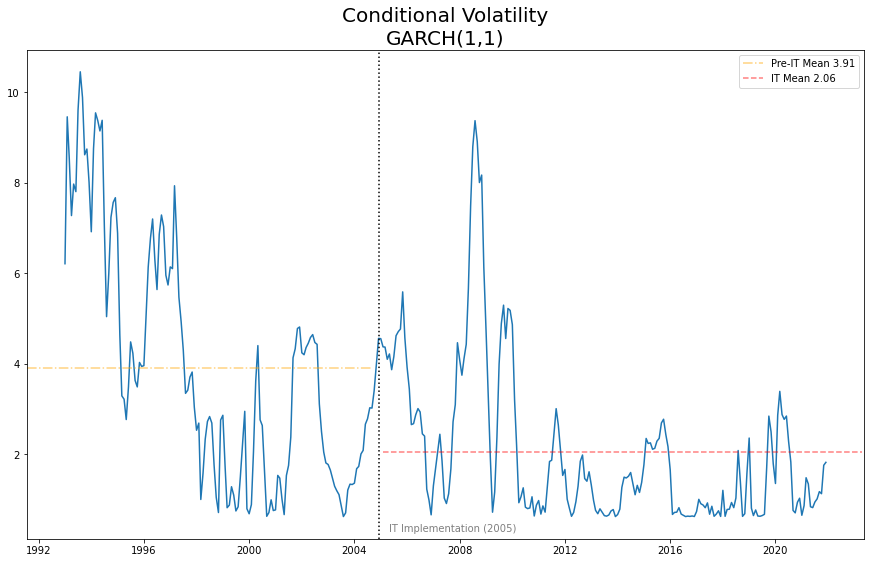

In [168]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-05-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)
plt.figure(figsize=(15,9))
plt.plot(resa2.conditional_volatility)
# res2.conditional_volatility.rolling(24).mean().plot(figsize=(15,9))
plt.title('Conditional Volatility\nGARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
plt.legend()

#### 1. 
**Observed Inflation**
- Mean Model:<br> 
  - ARX: Autoregressive model with optional exogenous regressors estimation and simulation
  - Controls: fao Index, US Inflation, petroleoum prices. (others?)<br>
- Volatility Process:<br> 
  - GARCH(p=1, o=0, q=1)


In [126]:

ar = ARX(simdf.v_cpi, x = cont[['fao_Index', 'cpiUS', 'pet']], lags=[1, 12, 24], constant=True) #HARCH
ar.volatility = GARCH(p=1, o=0, q=1)
resb1 = ar.fit(disp=False)
# resb1.summary()

In [127]:
# Period averages and differences
ITVolMean2bc  = resb1.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean2bc = resb1.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean2bc - ITVolMean2bc)

difference: 0.16496749912850373


In [128]:
# Test de diferencia de medias std

t_check=stats.ttest_ind(resb1.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        resb1.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])
else:
    print('pre IT mean is NOT statistically different from IT mean') 

pre IT mean is NOT statistically different from IT mean


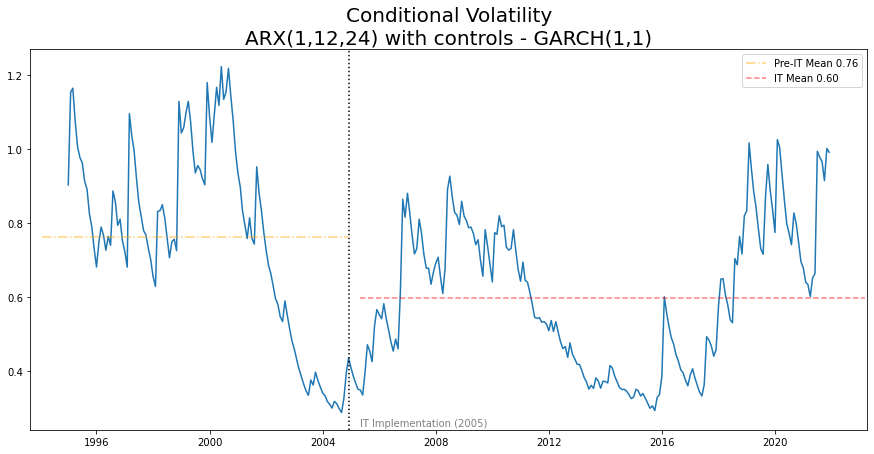

In [130]:
# pd.to_datetime(df_m.index[20])
plt.figure(figsize=(15,7))
plt.plot(resb1.conditional_volatility)
plt.title('Conditional Volatility\nARX(1,12,24) with controls - GARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2bc, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2bc))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2bc, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2bc))
plt.legend()

#### 2. 
**Observed Inflation**
- Mean Model:<br> 
  - HARX: Heterogeneous Autoregression (HAR), with optional exogenous regressors, model estimation and simulation
  - $y_t = \mu_t +\sum_{i=1}^p\phi L_i\bar{y}_{t-L_{i,0}:L_{i,1}} + \gamma'x_t + \epsilon_t$
  - where $\bar{y}_{t-L_{i,0}:L_{i,1}}$ is the average value of $y_t$ between $t -L_{i,0}$ and $t - L_{i,1}$ (average lags)
  - Controls: fao Index, US Inflation, petroleoum prices. (others?)<br>
- Volatility Process:<br> 
  - GARCH(p=1, o=0, q=1)


In [138]:

ar = HARX(simdf.v_cpi, x = cont[['fao_Index', 'cpiUS', 'pet']], lags=[1, 12, 24], constant=True) #HARCH
ar.volatility = GARCH(p=1, o=0, q=1)
resb2 = ar.fit(disp=False)
# resb1.summary()

In [132]:
# Period averages and differences
ITVolMean2bc  = resb2.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean2bc = resb2.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean2bc - ITVolMean2bc)

difference: 0.18713030672589515


In [133]:
# Test de diferencia de medias std

t_check=stats.ttest_ind(resb2.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        resb2.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])
else:
    print('pre IT mean is NOT statistically different from IT mean') 

pre IT mean is NOT statistically different from IT mean


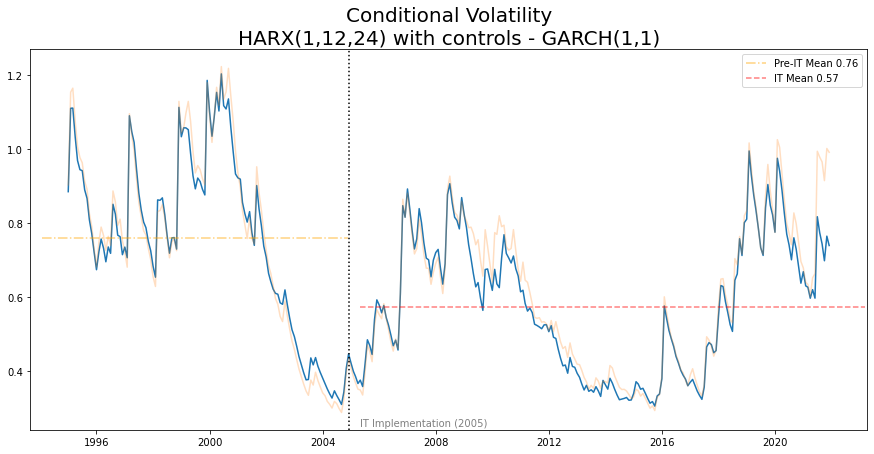

In [135]:
# pd.to_datetime(df_m.index[20])
plt.figure(figsize=(15,7))
plt.plot(resb2.conditional_volatility)
plt.plot(resb1.conditional_volatility, alpha=0.25)
plt.title('Conditional Volatility\nHARX(1,12,24) with controls - GARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2bc, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2bc))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2bc, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2bc))
plt.legend()

#### 3. 
**Observed Inflation**
- Mean Model:<br> 
  - LS: Least squares model estimation and simulation
    - $y_t = \mu_t + \gamma'x_t + \epsilon_t$
    - Controls: fao Index, US Inflation, petroleoum prices. (others?)<br>
- Volatility Process:<br> 
  - GARCH(p=1, o=0, q=1)


In [137]:

ar = LS(simdf.v_cpi, x = cont[['fao_Index', 'cpiUS', 'pet']], constant=True) #HARCH
ar.volatility = GARCH(p=1, o=0, q=1)
resb3 = ar.fit(disp=False)
# resb1.summary()

In [143]:
# Period averages and differences
ITVolMean3bc  = resb3.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean3bc = resb3.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean3bc - ITVolMean3bc)

difference: 1.6867577260563575


In [144]:
# Test de diferencia de medias std

t_check=stats.ttest_ind(resb3.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        resb3.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])
else:
    print('pre IT mean is NOT statistically different from IT mean') 

pre IT mean is statistically different from IT mean
6.769709186299544e-15


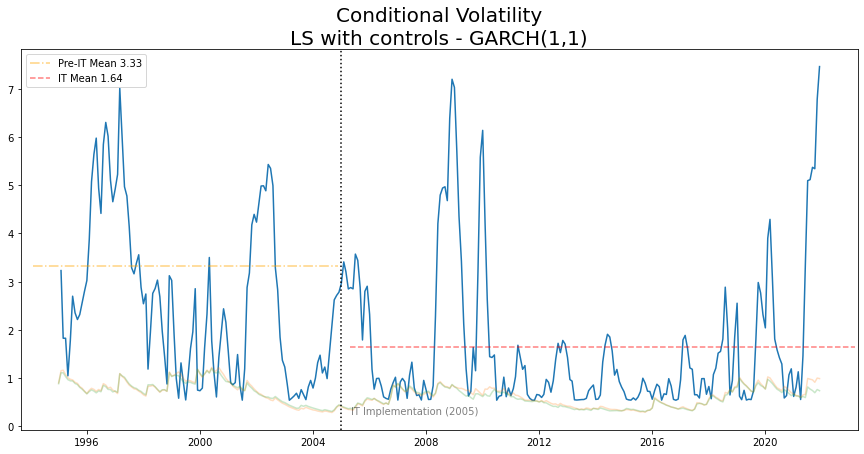

In [167]:
plt.figure(figsize=(15,7))
plt.plot(resb3.conditional_volatility[25:])
plt.plot(resb1.conditional_volatility, alpha=0.25)
plt.plot(resb2.conditional_volatility, alpha=0.25)
plt.title('Conditional Volatility\nLS with controls - GARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean3bc, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean3bc))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean3bc, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean3bc))
plt.legend()

#### Conditional volatility graphs for GARCH(1,1) with different mean models

In [169]:
# fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)

# plt.suptitle('Conditional Volatility Measures\nUnivariate GARCH Models', fontsize=20)

# # GARCH(1,1) on Seasonally Adjusted CPI Inflation
# axes[0,0].plot(resa1.conditional_volatility)
# axes[0,0].set_title('GARCH(1,1)\nSeasonally adjusted CPI Inflation', fontsize=12)
# axes[0,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
# axes[0,0].text(pd.to_datetime('2005-05-01'), 2.15, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
# axes[0,0].axhline(xmin=x0, xmax=x1, y=PreVolMean, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean))
# axes[0,0].axhline(xmin=x2, xmax=x3, y=ITVolMean, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean))
# axes[0,0].legend(loc='best', fontsize=9)
# # GARCH(1,1) on CPI Inflation
# axes[1,0].plot(resa2.conditional_volatility)
# axes[1,0].set_title('GARCH(1,1)\nCPI Inflation', fontsize=12)
# axes[1,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
# axes[1,0].text(pd.to_datetime('2004-12-01'),10.0, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
# axes[1,0].axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
# axes[1,0].axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
# axes[1,0].legend(loc='best', fontsize=9)
# # ARMA(p,q) / GARCH(p,q) model on Seasonally Adjusted CPI Inflation
# axes[0,1].plot(gamma_t2)
# axes[0,1].set_title('ARMA(2,4)/GARCH(2,4)\nSeasonally adjusted CPI Inflation', fontsize=12)
# axes[0,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
# axes[0,1].text(pd.to_datetime('2005-05-01'),1.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
# axes[0,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb2, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb2))
# axes[0,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb2, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb2))
# axes[0,1].legend(loc='lower left', fontsize=9)
# # ARMA(p,q) / GARCH(p,q) model on CPI Inflation
# axes[1,1].plot(gamma_t)
# axes[1,1].set_title('ARMA(1,1)/GARCH(1,1)\nCPI Inflation', fontsize=12)
# axes[1,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
# axes[1,1].text(pd.to_datetime('2004-12-01'),2.90, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
# axes[1,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb))
# axes[1,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb))
# axes[1,1].legend(loc='best', fontsize=10)

# plt.text(0.01, -0.15, 
# 'All differences between means are statistically significant at the 1% level', fontsize=10,transform=axes[1,0].transAxes)